<a href="https://colab.research.google.com/github/cbojechko/Image_Prediction/blob/main/dependances.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



Licensed under the Apache License, Version 2.0 (the "License");

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

#EPIDEEP: Generating EPID images

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/generative/pix2pix"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/generative/pix2pix.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/pix2pix.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/generative/pix2pix.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>


Workbook to make a prediction of in-vivo EPID images, using EPID images collected on the Varian Halcyon machine


## Import TensorFlow and other libraries

In [1]:
import tensorflow as tf

import os
import sys
import pathlib
import time
import datetime
import numpy as np
from matplotlib import pyplot as plt
from IPython import display
import tensorflow.experimental.numpy as tnp
import pandas as pd
#print(sys.version_info)

Connect to Google Drive to access data

In [2]:
running_local = False
try:
    from google.colab import drive
    drive.mount('/content/drive')
    nb_path = '/content/notebooks'
    os.symlink('/content/drive/MyDrive/Colab Notebooks', nb_path)
    sys.path.insert(0, nb_path)  # or append(nb_path)
except:
    running_local = True
    print("Running locally")

Mounted at /content/drive



Line to install pymedphys which has a gamma function which is used in model assessment. Also SimpleITK and   PlotScrollNumpyArrays

In [3]:
!pip install SimpleITK
!pip install pymedphys
!pip install PlotScrollNumpyArrays

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 20.5 MB/s eta 0:00:00


In [4]:
#import SimpleITK as sitk
import pymedphys

Get Data Generators from Brian's github, used for imported and pre-processing inputs.

In [5]:
!git clone --recurse-submodules -j8 https://github.com/brianmanderson/Data_Generators

Cloning into 'Data_Generators'...
remote: Enumerating objects: 1106, done.
remote: Counting objects: 100% (100/100), done.
remote: Compressing objects: 100% (72/72), done.
remote: Total 1106 (delta 50), reused 76 (delta 28), pack-reused 1006
Receiving objects: 100% (1106/1106), 525.72 KiB | 4.69 MiB/s, done.
Resolving deltas: 100% (696/696), done.
Submodule 'Image_Processors_Module' (https://github.com/brianmanderson/Image_Processors_Module.git) registered for path 'Image_Processors_Module'
Cloning into '/content/Data_Generators/Image_Processors_Module'...
remote: Enumerating objects: 1408, done.        
remote: Counting objects: 100% (198/198), done.        
remote: Compressing objects: 100% (86/86), done.        
remote: Total 1408 (delta 116), reused 154 (delta 75), pack-reused 1210        
Receiving objects: 100% (1408/1408), 321.42 KiB | 3.21 MiB/s, done.
Resolving deltas: 100% (892/892), done.
Submodule path 'Image_Processors_Module': checked out '8aa83f5122d585ab0ef2dbdf6a048d7b

In [6]:
from Data_Generators.TFRecord_to_Dataset_Generator import DataGeneratorClass
from Data_Generators.Image_Processors_Module.src.Processors.TFDataSets import ConstantProcessors as CProcessors,\
    RelativeProcessors as RProcessors

In [7]:
class ImageProcessor(object):
    def parse(self, *args, **kwargs):
        return args, kwargs
def _check_keys_(input_features, keys):
    if type(keys) is list or type(keys) is tuple:
        for key in keys:
            assert key in input_features.keys(), 'Make sure the key you are referring to is present in the features, ' \
                                                 '{} was not found'.format(key)
    else:
        assert keys in input_features.keys(), 'Make sure the key you are referring to is present in the features, ' \
                                              '{} was not found'.format(keys)
class DivideBasedOnOther(ImageProcessor):
    def __init__(self, guiding_keys=('annotation',), changing_keys=('image',)):
        self.guiding_keys, self.changing_keys = guiding_keys, changing_keys

    def parse(self, input_features, *args, **kwargs):
        _check_keys_(input_features=input_features, keys=self.guiding_keys)
        _check_keys_(input_features=input_features, keys=self.changing_keys)
        for guiding_key, changing_key in zip(self.guiding_keys, self.changing_keys):
            input_features[changing_key] = input_features[changing_key] / input_features[guiding_key]
        return input_features

Get the inputs, normalize, and subtract the primary attenuation function from the measured image.

In [8]:
def return_generator(records_path, proj_to_panel=True, add_5cm_keys=False, global_norm=False, **kwargs):
  generator = DataGeneratorClass(record_paths=records_path, delete_old_cache=True)
  all_keys = ('pdos_array', 'fluence_array','drr_array', 'deep_to_panel_array', 'iso_to_panel_array', 'shallow_to_panel_array')
  drr_keys = ('drr_array', 'deep_to_panel_array', 'iso_to_panel_array', 'shallow_to_panel_array', )
  input_keys = ('pdos_array', 'drr_array', 'iso_to_panel_array')
  if add_5cm_keys:
    if proj_to_panel:
      input_keys = ('pdos_array', 'drr_array', 'deep_to_panel_array', 'iso_to_panel_array',
                    'shallow_to_panel_array')
    else:
      input_keys = ('pdos_array', 'drr_array', '5cm_deep_array', 'iso_array', 'shallow_array')
  print(f"Inputs are {input_keys}")
  base_processors = [
      CProcessors.Squeeze(image_keys=all_keys),
      CProcessors.ExpandDimension(axis=-1, image_keys=all_keys),
      CProcessors.MultiplyImagesByConstant(keys=drr_keys,
                                           values=(1/255, 1/255, 1/255, 1/255)),
      RProcessors.AddMetricBasedOnImage(image_keys=('pdos_array',), methods=('reduce_max',), out_key_names=('pdos_max',))
                     ]

  if global_norm:
    print('Global norm')
    base_processors += [
                        CProcessors.MultiplyImagesByConstant(keys=('pdos_array',
                                                                'fluence_array'),
                                                             values=(1, 1)) #(1/2, 1/(.3876*2))
                        ]
  else:
    base_processors += [
                        RProcessors.NormalizeBasedOnOther(guiding_keys=('pdos_array', 'pdos_array'),
                                                          changing_keys=('fluence_array', 'pdos_array'),
                                                          reference_method=('reduce_max', 'reduce_max'),
                                                          changing_methods=('divide', 'divide'))
                        ]

    base_processors += [
    #CProcessors.CreateNewKey(input_keys=('drr_array',), output_keys=('exp_new_drr_array',)),
    #CProcessors.MultiplyImagesByConstant(keys=('exp_new_drr_array',), values=(-4.0,)),
    #CProcessors.TakeExpOfKey(input_keys=('exp_new_drr_array',)),

    CProcessors.CreateNewKey(input_keys=('drr_array',), output_keys=('mul_drr_array',)),
    CProcessors.MultiplyImagesByConstant(keys=('mul_drr_array',), values=(-2.970,)),
    #CProcessors.AddImagesTogether(keys=('new_drr_array', 'mul_drr_array'), out_key='new_drr_array'),

    CProcessors.CreateNewKey(input_keys=('drr_array',), output_keys=('squared_drr_array',)),
    CProcessors.MultiplyImagesTogether(keys=('squared_drr_array', 'squared_drr_array'), out_key='squared_drr_array'),
    CProcessors.MultiplyImagesByConstant(keys=('squared_drr_array',), values=(0.538066,)),
    CProcessors.AddImagesTogether(keys=('mul_drr_array', 'squared_drr_array'), out_key='summed_drr_array'),

    CProcessors.AddConstantToImages(keys=('summed_drr_array',),values=(-0.04349,)),

    CProcessors.TakeExpOfKey(input_keys=('summed_drr_array',)),
    CProcessors.MultiplyImagesTogether(keys=('pdos_array', 'summed_drr_array'), out_key='summed_array'),
    CProcessors.MultiplyImagesByConstant(keys=('summed_array',), values=(-1.0,)),

    CProcessors.AddImagesTogether(keys=('fluence_array', 'summed_array'), out_key='scatter_array'),

  ]


  base_processors += [
                      CProcessors.CombineKeys(axis=-1,
                                              image_keys=input_keys,
                                              output_key='output'),
                      CProcessors.ReturnOutputs(input_keys=('output','pdos_max'),
                                                #output_keys=('fluence_array',))
                                                output_keys=('scatter_array',))
                                                #output_keys=('summed_array',))
  ]
  base_processors += [
                      {'batch': 1}, {'repeat'}
                      ]
  generator.compile_data_set(image_processors=base_processors, debug=False)
  return generator

In [ ]:
def load_data_from_generator(generator):
  data = {'input' : [], 'rtimg' : []}
  iterator = iter(generator.data_set)
  for _ in range(len(generator)):
    x, y = next(iterator)
    data['input'].append(x[0][0])
    data['rtimg'].append(y[0][0])
  return data

# Return a train and validation dataset (test data set for testing out different phantom vs patient data)





In [9]:
def return_datasets(data_generators):
  all_datasets = {}
  for i in data_generators.keys():
    generator = data_generators[i]
    all_datasets[i] = tf.data.Dataset.from_tensor_slices((load_data_from_generator(generator)))
  return all_datasets

def return_fold_datasets(data_generators, batch_size=1):
  all_datasets = return_datasets(data_generators)

  train_dataset = all_datasets['train']
  train_dataset = train_dataset.shuffle(len(train_dataset))
  train_dataset = train_dataset.batch(int(batch_size))

  valid_dataset = all_datasets['validation']
  valid_dataset = valid_dataset.shuffle(len(valid_dataset))
  valid_dataset = valid_dataset.batch(1)

  test_dataset = all_datasets['test']
  test_dataset = test_dataset.shuffle(len(test_dataset))
  test_dataset = test_dataset.batch(1)
  return train_dataset, valid_dataset, test_dataset

In [10]:
def return_dataset(generator, batch):
  input_values = []
  output_values = []
  iterator = iter(generator.data_set)
  for _ in range(len(generator)):
    x, y = next(iterator)
    input_values.append(x[0][0])
    output_values.append(y[0][0])
  input_dataset = tf.data.Dataset.from_tensor_slices(input_values)
  output_dataset = tf.data.Dataset.from_tensor_slices(output_values)
  dataset = tf.data.Dataset.zip((input_dataset, output_dataset))
  dataset = dataset.shuffle(len(dataset)).batch(int(batch))
  return dataset

In [12]:
def return_generators(base_path, excluded_fold=5, batch=10, **kwargs):
  data_generators = {}
  train_folder_names = []
  val_folder_names = []
  test_folder_names = []
  #train_folder_names.append(os.path.join(base_path, 'onefrac_train'))
  #val_folder_names.append(os.path.join(base_path, 'onefrac_valid'))
  train_folder_names.append(os.path.join(base_path, 'train2'))
  val_folder_names.append(os.path.join(base_path, 'valid2'))
  #test_folder_names.append(os.path.join(base_path, 'phantom_valid'))
  #test_folder_names.append(os.path.join(base_path, 'test_pelvis'))
  #test_folder_names.append(os.path.join(base_path, 'Prostate2_pCT'))
  #test_folder_names.append(os.path.join(base_path, 'phantom_one'))
  #test_folder_names.append(os.path.join(base_path, 'phantom_pCT'))
  test_folder_names.append(os.path.join(base_path, 'test2'))

  # for i in range(1,6):
  #   folder_name = '/content/drive/My Drive/data/fold{}'.format(i)
  #   if i != excluded_fold:
  #     train_folder_names.append(folder_name)
  #   else:
  #     val_folder_names.append(folder_name)

  train_gen = return_generator(train_folder_names, batch=batch, **kwargs)
  train_gen = return_dataset(train_gen, batch)

  valid_gen = return_generator(val_folder_names, batch=batch, **kwargs)
  valid_gen = return_dataset(valid_gen, 1)

  test_gen = return_generator(test_folder_names, batch=batch, **kwargs)
  test_gen = return_dataset(test_gen, 1)


  return train_gen, valid_gen, test_gen

In [13]:
batch = 1
base_path = '/content/drive/My Drive/data'
train_dataset, valid_dataset, test_dataset = return_generators(base_path, excluded_fold=1, batch=batch)

Inputs are ('pdos_array', 'drr_array', 'iso_to_panel_array')
{'batch': 1}
{'repeat'}
Inputs are ('pdos_array', 'drr_array', 'iso_to_panel_array')
{'batch': 1}
{'repeat'}
Inputs are ('pdos_array', 'drr_array', 'iso_to_panel_array')
{'batch': 1}
{'repeat'}


Some code to double check the input

In [ ]:
iterx = iter(test_dataset.repeat())

In [14]:
train_len = len(train_dataset)
valid_len = len(valid_dataset)
test_len =  len(test_dataset)
x, y = next(iterx)
print(train_len)
print(valid_len)
print(test_len)
plt.imshow(x[0,...,0])

NameError: name 'iterx' is not defined

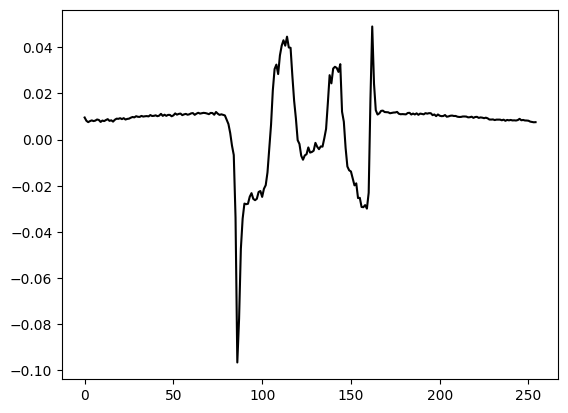

In [15]:
#train_len = len(train_dataset)
#valid_len = len(valid_dataset)
#test_len =  len(test_dataset)

itery = iter(test_dataset.repeat())
x, y = next(itery)
#print(train_len)
#print(valid_len)
#print(test_len)
#plt.imshow(y[0,...,0])

rt = y[0,...,0].numpy()

pdos = x[0,...,0].numpy()
cbct = x[0,...,1].numpy()
#plt.plot(pdos[128,1:256],'b')
#plt.plot(cbct[128,1:256],'r')
plt.plot(rt[128,1:256],'k')
#plt.ylim([-0.05,0.1])
#plt.ylim([0.86,0.92])
#plt.ylim([0.58,0.6])
plt.show()

In [16]:
train_len = len(train_dataset)
valid_len = len(valid_dataset)
#test_len =  len(test_dataset)
x, y = next(iterx)
#print(train_len)
#print(valid_len)
#print(test_len)
#plt.imshow(y[0,...,0])

rt = y[0,...,0].numpy()

pdos = x[0,...,0].numpy()
cbct = x[0,...,1].numpy()

plt.figure(figsize=(10, 10))
plt.subplot(1,3,1)

plt.imshow(rt)
#plt.plot(pdos[128,1:256],'b')
#plt.plot(cbct[128,1:256],'r')

#plt.show()

cbctval = []
ratio = []
pdosval = []

rtmax = rt.max(0).max(-1)
#print(rtmax)

for i in range(0,256):
  for j in range(0,256):
    if(rt[i,j] > rtmax*0.5):
      cbctval = np.append(cbctval,cbct[i,j])
      pdosval = np.append(pdosval,pdos[i,j])
      ratio = np.append(ratio,rt[i,j]/pdos[i,j])

plt.subplot(1,3,2)
plt.plot(cbctval,ratio,'bo')

#xp = np.arange(0, 200.0, 0.1)
#yp = np.exp(-4.0/255 * xp) + 0.15/255 * xp - 0.1/65025 * xp * xp
# #yp = pdosval*( np.exp(-4.0/255 *cbctval) + 0.15/255 * cbctval - 0.1/65025 * cbctval * cbctval)
xp = np.arange(0, 1.0, 0.01)
#yp = np.exp(-4.0 * xp) + 0.15 * xp -0.1* xp * xp
#yp = np.exp(-4.0 * xp)
yp = np.exp(0.538066*xp*xp-2.970*xp-0.04349)

plt.plot(xp, yp,'r')

#plt.subplot(1,3,3)
#plt.plot(rt[128,1:256]/pdos[128,1:256],'b')
#plt.plot(pdos[128,1:256],'r')
#plt.plot(rt[128,1:256],'b')

NameError: name 'iterx' is not defined

You can inspect some of the preprocessed output:

In [18]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

Define the upsampler (decoder):

In [19]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [20]:
def Generator(kernel_size=4, layers=7, filters_start=64, double_layers=4, add_5cm_keys=False, activation='tanh', **kwargs):
  """
  default values creates the original generator, filters double from start
  to a max after the number of 'double layers'
  kernel_size is the kernel size
  Layers is the number of layers
  """
  channels = 3
  if add_5cm_keys:
    channels = 5
  inputs = tf.keras.layers.Input(shape=[256, 256, channels])
  filters_list = []
  for _ in range(double_layers):
    filters_list.append(filters_start)
    filters_start *= 2
  up_filters = []
  batchnorm = False
  down_stack = []
  for _ in range(layers):
    if filters_list:
      filters = filters_list.pop(0)
    up_filters.append(filters)
    layer = downsample(filters, kernel_size, batchnorm)
    down_stack.append(layer)
    batchnorm = True
  if filters_list:
    filters = filters_list.pop(0)
  layer = downsample(filters, kernel_size, batchnorm)
  down_stack.append(layer)
  up_stack = []
  for _ in range(layers):
    filters = up_filters.pop()
    layer = upsample(filters, kernel_size)
    up_stack.append(layer)
  initializer = tf.random_normal_initializer(0., 0.02)
  if activation == 'Linear':
    activation = None
  last = tf.keras.layers.Conv2DTranspose(1, kernel_size,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation=activation)  # (batch_size, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

Visualize the generator model architecture (or summerize):

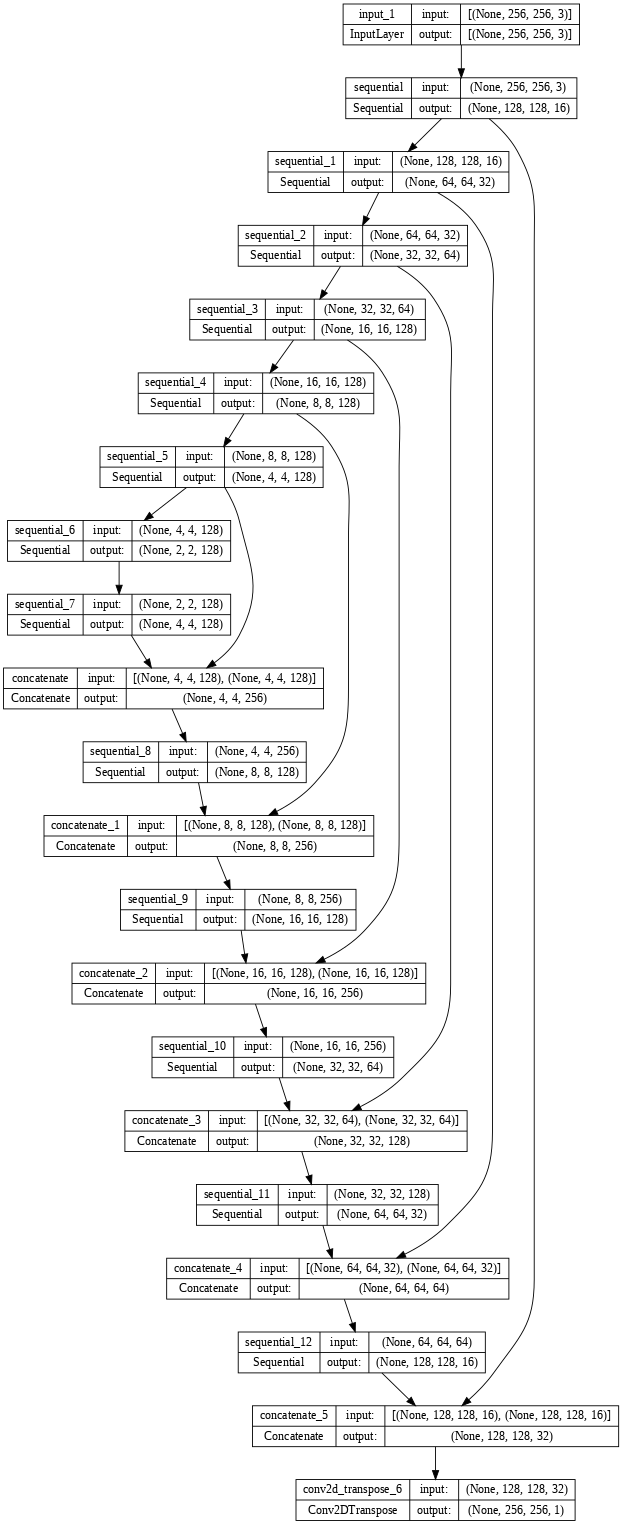

In [21]:
generator = Generator(kernel_size=4, layers=6, filters_start=16, double_layers=4)
#generator = GeneratorS2(kernel=32)
#generator = GeneratorFixed2()
#generator = GeneratorExpSca()
#generator = GeneratorLK()
#generator = GeneratorE()
#generator = GeneratorDCNN()
#generator = GeneratorDSE()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)
#generator.summary()

Test the generator:

In [ ]:
for val in train_dataset.take(1):
  inp = val[0]
  #inp = tf.squeeze(inp,axis=-1)
  #print(inp)

tf.Tensor([  2 256 256   3], shape=(4,), dtype=int32)
tf.Tensor([  1   2 256 256   3], shape=(5,), dtype=int32)


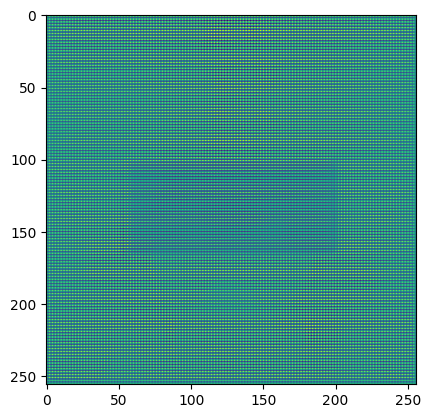

In [ ]:
print(tf.shape(inp))
print(tf.shape(inp[tf.newaxis, ...]))
gen_output = generator(inp, training=False)
#gen_output = generator(inp[tf.newaxis, ...], training=False)
# #print(tf.shape(gen_output))
plt.imshow(tf.squeeze(gen_output[0, ...],axis=-1))

### Define the generator loss



In [ ]:
def plot_images(prediction, input, target):
  plt.figure(figsize=(15, 10))


  display_list = [ input[0], target[0], prediction[0] ]
  title = ['Input CBCT Image', 'Ground Truth', 'Predicted Image']

  plt.subplot(1, 4, 1)
  plt.title('Input Image')
  # Getting the pixel values in the [0, 1] range to plot.

  input = tf.squeeze(input,axis=0)
  inslice = input[...,1]

  plt.imshow(inslice)
  plt.axis('off')

  plt.subplot(1, 4, 2)
  plt.title('Ground Truth')

  plt.imshow(tf.squeeze(target[0],axis=-1))
  plt.axis('off')

  plt.subplot(1, 4, 3)
  plt.title('Predicted Image')
  plt.imshow(tf.squeeze(prediction))
  plt.axis('off')

  target = tf.squeeze(target)
  prediction = tf.squeeze(prediction)

  predvec = prediction[128,1:256]
  rtvec = target[128,1:256]


  plt.axis('off')
  plt.subplot(1, 4, 4)
  plt.plot(rtvec,'g')
  plt.title("Meas RT IMG (Green)")
  plt.plot(predvec,'b')

  # Getting the pixel values in the [0, 1] range to plot.
  #print(tf.shape(prediction))
  #prediction = tf.cast(prediction,tf.float32)
  #plt.imshow(tf.squeeze(prediction[0],axis=-1))
  #plt.axis('off')

  plt.show()

In [ ]:
from tensorflow.python.ops import math_ops
sobel_fraction = 0.5
class MGELoss(tf.keras.losses.Loss):
  def call(self, y_true, y_pred):
    y_pred = tf.convert_to_tensor(y_pred)
    y_true = tf.cast(y_true, y_pred.dtype)
    l1_loss = tf.reduce_mean(math_ops.abs(y_pred - y_true), axis=-1)
    sobel = tf.image.sobel_edges(y_pred)
    p_sobel = tf.reduce_mean(math_ops.abs(sobel), axis=-1)
    loss_sobel = tf.reduce_mean(math_ops.abs(y_pred - p_sobel), axis=-1)
    loss = l1_loss*(1-sobel_fraction) + loss_sobel * sobel_fraction
    return loss

In [ ]:
mae = tf.keras.metrics.MeanAbsoluteError()
mae_loss = tf.keras.losses.MeanAbsoluteError()
#mae_loss = MGELoss()
#mae_loss = CustomWeigthed()

In [ ]:
stop

NameError: ignored

In [22]:
generator = Generator(kernel_size=4, layers=6, filters_start=16, double_layers=4)
generator.load_weights('/content/drive/MyDrive/Colab Notebooks/logs_CB/batch2new/final_model.h5')

In [ ]:
stop

In [ ]:
epochs = 501
train_gen = train_dataset
val_gen = valid_dataset
#train_gen = data_generators['train']
#val_gen = data_generators['validation']
dilation_kernel = 3
scatter = True
add_half = False

exp_lr = tf.keras.optimizers.schedules.ExponentialDecay(1.0e-5,decay_steps=5000,decay_rate=0.5)
#cos_lr = tf.keras.optimizers.schedules.CosineDecay(2.0e-5,decay_steps=20000)


for lr in [8.0e-6]:

  #generator = GeneratorE2()
  generator = Generator(kernel_size=4, layers=6, filters_start=16, double_layers=4)
  #generator = GeneratorB(size=4, layers=7, filters_start=4, double_layers=4)
  tensorboard_output = "/content/drive/MyDrive/Colab Notebooks/logs_CB/batch2_exp"
  print(tensorboard_output)

  if not os.path.exists(tensorboard_output):
    os.makedirs(tensorboard_output)
  else:
    print("bah")
    #continue
  tensorboard = tf.keras.callbacks.TensorBoard(log_dir=tensorboard_output,
                                                      profile_batch=0,
                                                      write_graph=False)
  generator.compile(optimizer=tf.keras.optimizers.Adam(exp_lr, beta_1=0.9),
                          loss=mae_loss, metrics=[mae])

  #print(exp_lr)
  generator.fit(train_gen, steps_per_epoch=len(train_gen),
                      validation_data=val_gen, epochs=epochs, validation_freq=5,
                      validation_steps=len(val_gen), callbacks=[tensorboard])
  generator.save(os.path.join(tensorboard_output, 'final_model.h5'))

In [ ]:
%reload_ext tensorboard

In [ ]:
%tensorboard --logdir '/content/drive/MyDrive/Colab Notebooks/logs_CB/'

The training procedure for the discriminator is shown below.

To learn more about the architecture and the hyperparameters you can refer to the [pix2pix paper](https://arxiv.org/abs/1611.07004).

## Define the optimizers and a checkpoint-saver


## Generate some images using the test set

In [23]:
gamma_options = {
    'dose_percent_threshold': 3,
    'distance_mm_threshold': 3,
    'lower_percent_dose_cutoff': 10,
    'interp_fraction': 20,  # Should be 10 or more, see the paper referenced above
    'max_gamma': 2,
    'random_subset': None,  # Can be used to get quick pass rates
    'local_gamma': False,  # Change to false for global gamma
    'ram_available': 2**29  # 1/2 GB
}

In [24]:
xepidmin = -215.04
xepidmax = 215.04
yepidmin = -215.04
yepidmax = 215.04
grid = 1.68
xepid = np.arange(xepidmin,xepidmax,grid)
yepid = np.arange(yepidmin,yepidmax,grid)
coords = (yepid,xepid)

1/1 [==============================] - 0s 22ms/step
Calcing using global normalisation point for gamma
Global normalisation set to 1.6948012113571167
Global dose threshold set to [0.05084404] ([3]% of normalisation)
Distance threshold set to [3]
Lower dose cutoff set to 0.16948012113571168 (10% of normalisation)

Current distance: 5.85 mm | Number of reference points remaining: 1369 | Points tested per reference point: 247 | RAM split count: 1
Complete!


Text(0.5, 1.0, 'Local Gamma (3%/3mm) | Percent Pass: 45.00 %')

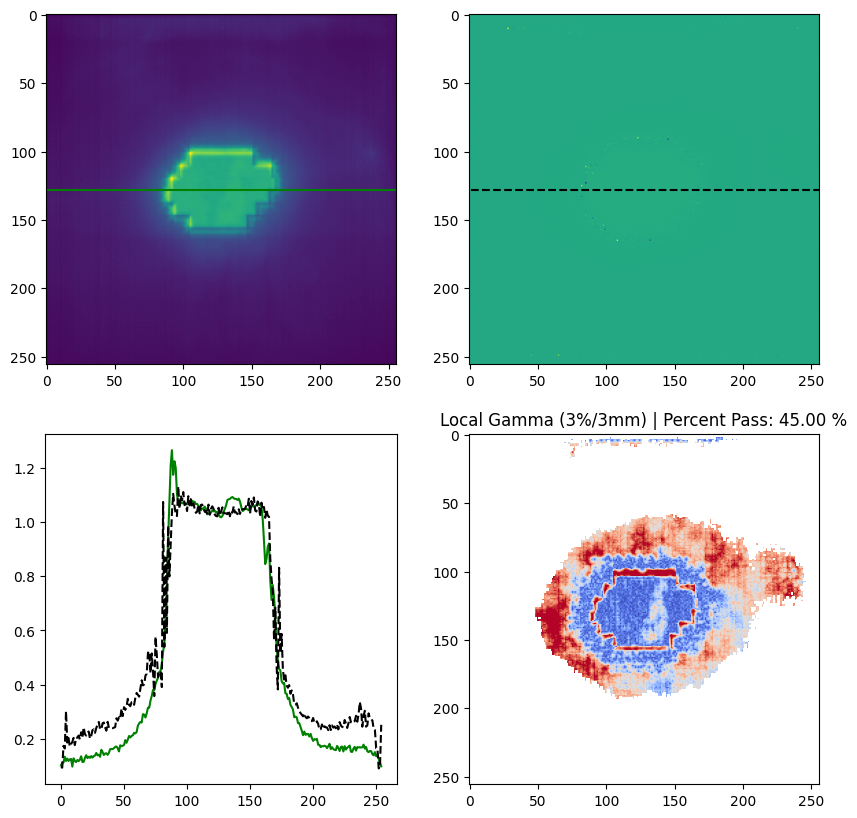

In [31]:
example = next(iter(test_dataset))
input = example[0]
#print(tf.shape(cbct_input))
tar = example[1]
#prediction = generator(input, training=True)
prediction = generator.predict(input)

diff = tf.subtract(tar,prediction)
diff = tf.squeeze(diff, axis=0)
diffvec = diff[120,1:256]
tar = tf.squeeze(tar, axis=0)
tar = tf.squeeze(tar, axis=-1)
rtimage = tar

pdos = input[0,...,0].numpy()
cbct = input[0,...,1].numpy()
half = input[0,...,2].numpy()


prediction = tf.squeeze(prediction, axis=0)
prediction = tf.squeeze(prediction, axis=-1)
prediction = prediction
crossval = 128

#rtprim = pdos*(1.0*np.exp(0.538066**cbct*cbct-2.970*cbct-0.04349))
#predprim = pdos*(1.0*np.exp(0.538066**cbct*cbct-2.970*cbct-0.04349))

rtimage = pdos*(1.0*np.exp(0.538066**cbct*cbct-2.970*cbct-0.04349)) + rtimage
prediction = pdos*(1.0*np.exp(0.538066**cbct*cbct-2.970*cbct-0.04349)) + prediction

#rtfull = pdos*(1.0*np.exp(0.538066**cbct*cbct-2.970*cbct-0.04349)) + rtimage
#predfull = pdos*(1.0*np.exp(0.538066**cbct*cbct-2.970*cbct-0.04349)) + prediction

#rtimage = rtprim/rtfull
#prediction = predprim/predfull

plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
x = [1, 256]
y = [crossval, crossval]
plt.plot(x, y, color="g")
plt.imshow(rtimage)

plt.subplot(2, 2, 2)
plt.plot(x, y, "k--")
plt.imshow(prediction)

predvec = prediction[128,1:256]
rtvec = rtimage[128,1:256]

#predvec = prediction[1:256,128]
#rtvec = rtimage[1:256,128]



plt.subplot(2, 2, 3)
plt.plot(rtvec,'g')
#plt.title("Meas RT IMG (Green)")
plt.plot(predvec,'k--')
#plt.ylim([0,0.6])
#print(str(example["fname"]))

gamma_test = pymedphys.gamma(coords,rtimage, coords, prediction, **gamma_options)
valid_gamma = gamma_test[~np.isnan(gamma_test)]

num_bins = (
    gamma_options['interp_fraction'] * gamma_options['max_gamma'])
bins = np.linspace(0, gamma_options['max_gamma'], num_bins + 1)

#gamma_no_noise = pymedphys.gamma(coords, rtimage, coords, prediction,**gamma_options)
plt.subplot(2, 2, 4)

plt.imshow( gamma_test, clim=(0, 2), cmap='coolwarm')

# plt.hist(valid_gamma, bins, density=True)
# plt.xlim([0, gamma_options['max_gamma']])
pass_ratio = np.sum(valid_gamma <= 1) / len(valid_gamma)
plt.title(f"Local Gamma ({gamma_options['dose_percent_threshold']}%/{gamma_options['distance_mm_threshold']}mm) | Percent Pass: {pass_ratio*100:.2f} %")

In [ ]:
plt.imshow(gamma_test)

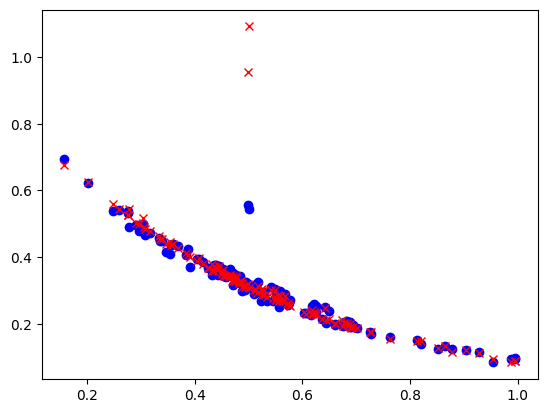

In [26]:
caxcb = []
caxrt = []
caxpred = []
caxhalf = []
dataset = train_dataset

all_ratios = np.zeros(len(list(dataset)))

for example in dataset:
  tinp = example[0]
  ttar = example[1]
  inp = tf.squeeze(tinp,axis=0)
  #slicen = 1
  pdos = tinp[0,...,0].numpy()
  cbct = tinp[0,...,1].numpy()
  half = tinp[0,...,2].numpy()
  cbctcax = np.mean(cbct[126:130,126:130] )
  pdoscax = np.mean(pdos[126:130,126:130] )
  halfcax = np.mean(half[126:130,126:130] )
  #prediction = generator.predict(tinp)
  prediction = generator(tinp, training=True)
  #ttar = tf.squeeze(ttar, axis=0)
  #ttar = tf.squeeze(ttar, axis=-1)
  rtimage = ttar[0,...,0].numpy()


  #out = "cbctcax {} rtcax {}".format(cbctcax,rtcax/pdoscax)
  #print(out)
  prediction = tf.squeeze(prediction, axis=0)
  prediction = tf.squeeze(prediction, axis=-1)

  rtimage = pdos*(1.0*np.exp(0.538066**cbct*cbct-2.970*cbct-0.04349)) + rtimage
  prediction = pdos*(1.0*np.exp(0.538066**cbct*cbct-2.970*cbct-0.04349)) + prediction


  rtcax = np.mean(rtimage[126:130,126:130])
  predcax = np.mean(prediction[126:130,126:130])
  caxcb = np.append(caxcb,cbctcax)
  caxrt = np.append(caxrt,rtcax/pdoscax)
  caxpred = np.append(caxpred,predcax/pdoscax)
  caxhalf = np.append(caxhalf,halfcax)

#ax = plt.axes(projection='3d')
#ax.scatter3D(caxcb, caxhalf, caxrt, c='b' )
#ax.scatter3D(caxcb, caxhalf, caxpred, c='r' )
#plt.show()


plt.plot(caxcb,caxrt,'bo')
plt.plot(caxcb,caxpred,'rx')

#plt.plot(caxhalf,caxrt,'bo')
#plt.plot(caxhalf,caxpred,'ro')
#plt.ylim([0.8, 1.0])
#plt.xlim([0., 0.1])
plt.show()

133
0.9547340083596567
0.988279574038068
0.9714345050333631
0.9310184237304734
0.9650425280197417
0.9730250752956157
0.9964420610623068
0.9445527862717708
0.9343546783367696
0.9959641449560799
0.985139966093903
0.9764123647686612
0.9291565136250607
0.9525749239398573
0.954086567119552
0.9727635581961133
0.948002199573469
0.9842447099737729
0.9878477821164763
0.9920156954225056
0.9648501308753359
0.9988987416073843
0.9946504489753577
0.966780938629386
0.970997609079665
0.9887552475314596
0.9866112588040149
0.9821265842431401
0.9090285766821145
0.9747820415450523
0.9922920075677163
0.9568512651820287
0.9757727324061378
0.9782939878200944
0.9315163702699532
0.9677404962138157
0.9823678305338882
0.9595171991881395
0.9893644663996966
0.9926777498368713
0.9950257760821835
0.9754688377536043
0.9939740879788699
0.9932842478298511
0.9493044720419102
0.997766602353936
0.9585592432656089
0.9926247846811297
0.9862954410292364
0.9929151778114661
0.9588231057277429
0.9775768929868316
0.9913281086912

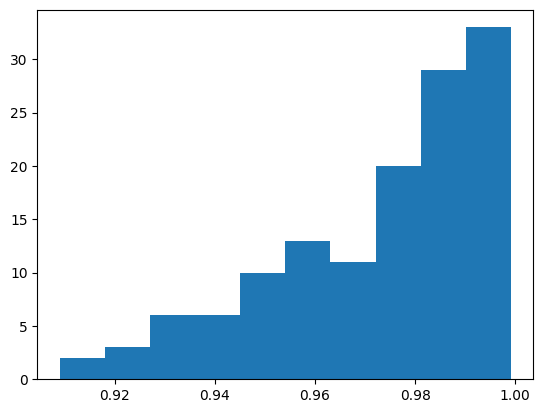

In [70]:
dataset = train_dataset
print(len(list(dataset)))
all_val = np.zeros(len(list(dataset)))
i = 0
i90 = 0
for example in dataset:
  tinp = example[0]
  ttar = example[1]
  #prediction = generator(tinp, training=True)
  prediction = generator.predict(tinp,verbose=0)
  ttar = tf.squeeze(ttar, axis=0)
  ttar = tf.squeeze(ttar, axis=-1)
  rtimage = ttar

  prediction = tf.squeeze(prediction, axis=0)
  prediction = tf.squeeze(prediction, axis=-1)
  prediction = prediction

  pdos = tinp[0,...,0].numpy()
  cbct = tinp[0,...,1].numpy()
  half = tinp[0,...,2].numpy()

  rtprim = pdos*(1.0*np.exp(0.538066**cbct*cbct-2.970*cbct-0.04349))
  predprim =  pdos*(1.0*np.exp(0.538066**cbct*cbct-2.970*cbct-0.04349))

  rtfull = pdos*(1.0*np.exp(0.538066**cbct*cbct-2.970*cbct-0.04349)) + rtimage
  predfull = pdos*(1.0*np.exp(0.538066**cbct*cbct-2.970*cbct-0.04349)) + prediction


  tmask = rtfull < np.max(rtfull) *0.1


  rtfrac = rtprim/rtfull
  a = np.ma.array(rtprim,mask=tmask)
  b= np.ma.array(rtfull,mask=tmask)

  frac = a.mean()/b.mean()
  if(frac > 1.0):
    frac = 1.0/frac
  print(frac)

  all_val[i] = frac
  i = i+1


plt.hist(all_val)
plt.show()


40
94.52546555979359 ,
80.63088781044819 ,
Calcing using global normalisation point for gamma
Global normalisation set to 0.19153988361358643
Global dose threshold set to [0.0057462] ([3]% of normalisation)
Distance threshold set to [3]
Lower dose cutoff set to 0.019153988361358645 (10% of normalisation)

Current distance: 5.85 mm | Number of reference points remaining: 709 | Points tested per reference point: 247 | RAM split count: 1
Complete!


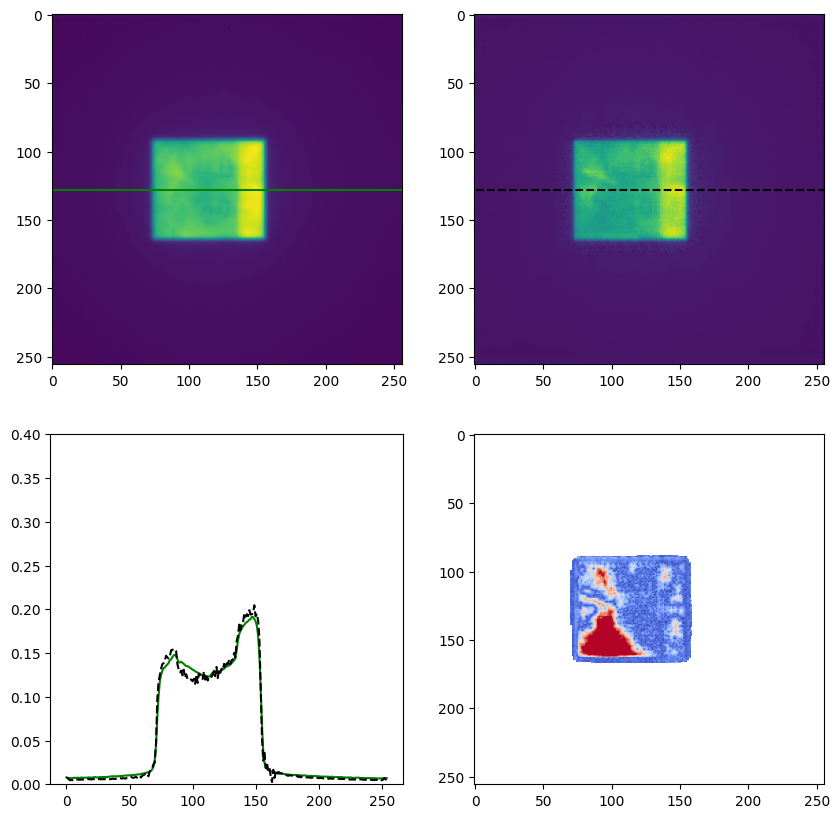

100.0 ,
95.29636281993713 ,
92.6818233231535 ,
99.85738055621583 ,
89.69652471855115 ,
Calcing using global normalisation point for gamma
Global normalisation set to 0.13431796431541443
Global dose threshold set to [0.00402954] ([3]% of normalisation)
Distance threshold set to [3]
Lower dose cutoff set to 0.013431796431541444 (10% of normalisation)

Current distance: 5.85 mm | Number of reference points remaining: 4 | Points tested per reference point: 247 | RAM split count: 1
Complete!


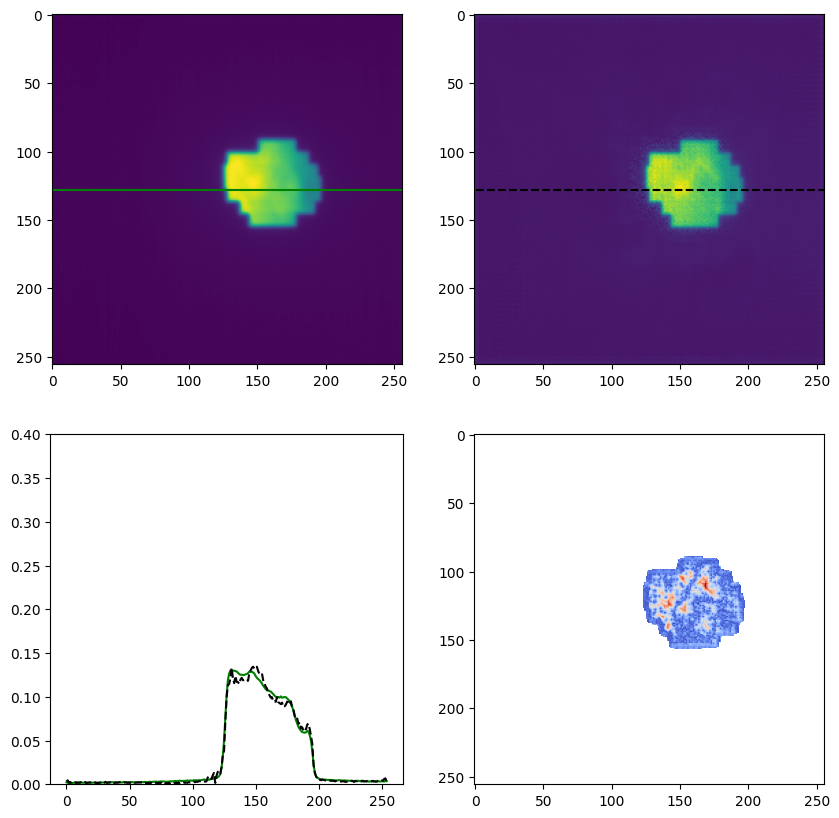

96.33068081343943 ,
95.59778686552802 ,
75.69373072970195 ,
Calcing using global normalisation point for gamma
Global normalisation set to 0.4146862030029297
Global dose threshold set to [0.01244059] ([3]% of normalisation)
Distance threshold set to [3]
Lower dose cutoff set to 0.04146862030029297 (10% of normalisation)

Current distance: 5.85 mm | Number of reference points remaining: 643 | Points tested per reference point: 247 | RAM split count: 1
Complete!


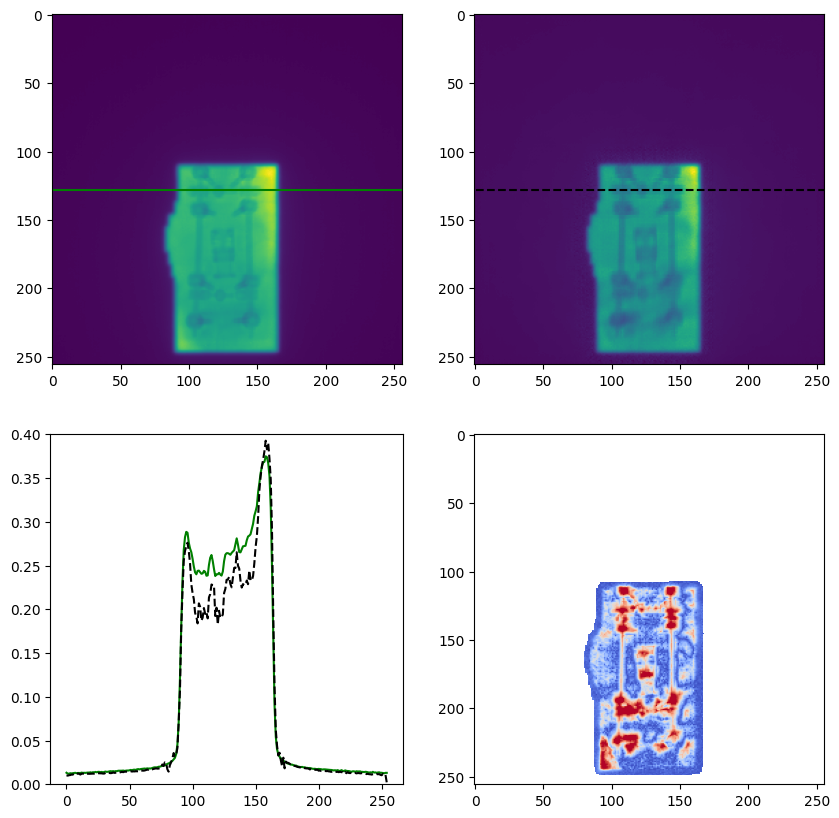

90.82731160595783 ,
94.42616099879851 ,
81.52312803475594 ,
Calcing using global normalisation point for gamma
Global normalisation set to 0.542059063911438
Global dose threshold set to [0.01626177] ([3]% of normalisation)
Distance threshold set to [3]
Lower dose cutoff set to 0.0542059063911438 (10% of normalisation)

Current distance: 5.85 mm | Number of reference points remaining: 45 | Points tested per reference point: 247 | RAM split count: 1
Complete!


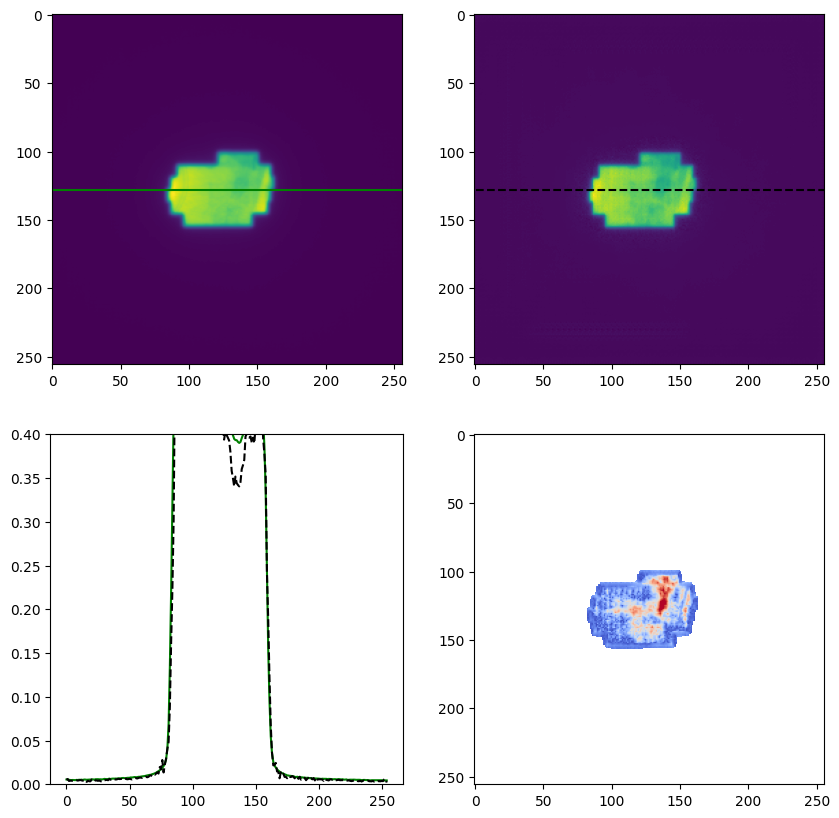

92.28408592722491 ,
97.44031503814915 ,
90.05248091603053 ,
97.57377979568672 ,
95.13105817340004 ,


KeyboardInterrupt: 

In [71]:
dataset = test_dataset
print(len(list(dataset)))
all_ratios = np.zeros(len(list(dataset)))
i = 0
i90 = 0
for example in dataset:
  tinp = example[0]
  ttar = example[1]
  #prediction = generator(tinp, training=True)
  prediction = generator.predict(tinp,verbose=0)
  ttar = tf.squeeze(ttar, axis=0)
  ttar = tf.squeeze(ttar, axis=-1)
  rtimage = ttar

  prediction = tf.squeeze(prediction, axis=0)
  prediction = tf.squeeze(prediction, axis=-1)
  prediction = prediction

  pdos = tinp[0,...,0].numpy()
  cbct = tinp[0,...,1].numpy()
  half = tinp[0,...,2].numpy()


  rtimage = pdos*(1.0*np.exp(0.538066**cbct*cbct-2.970*cbct-0.04349)) + rtimage
  prediction = pdos*(1.0*np.exp(0.538066**cbct*cbct-2.970*cbct-0.04349)) + prediction


  gamma_test = pymedphys.gamma(coords,rtimage, coords, prediction, **gamma_options,quiet=True)
  valid_gamma = gamma_test[~np.isnan(gamma_test)]
  pass_ratio = np.sum(valid_gamma <= 1) / len(valid_gamma)
  #tf.print(example["fname"])
  print(str(100*pass_ratio) +' ,')
  #print(i)
  all_ratios[i] = pass_ratio
  i = i+1
  if(pass_ratio > 0.90):
    i90 = i90+1

  if(pass_ratio < 0.90):

    plt.figure(figsize=(10, 10))
    crossval =128
    plt.subplot(2, 2, 1)
    x = [1, 256]
    y = [crossval, crossval]
    plt.plot(x, y, color="g")
    plt.imshow(rtimage)

    plt.subplot(2, 2, 2)
    plt.plot(x, y, "k--")
    plt.imshow(prediction)

    predvec = prediction[crossval,1:256]
    rtvec = rtimage[crossval,1:256]
    #predvec = prediction[1:256,crossval]
    #rtvec = rtimage[1:256,crossval]

    plt.subplot(2, 2, 3)
    plt.plot(rtvec,'g')
    #plt.title("Meas RT IMG (Green)")
    plt.plot(predvec,'k--')
    plt.ylim([0,0.40])
    #print(str(example["fname"]))

    gamma_test = pymedphys.gamma(coords,rtimage, coords, prediction, **gamma_options)
    valid_gamma = gamma_test[~np.isnan(gamma_test)]

    num_bins = (
      gamma_options['interp_fraction'] * gamma_options['max_gamma'])
    bins = np.linspace(0, gamma_options['max_gamma'], num_bins + 1)

    #gamma_no_noise = pymedphys.gamma(coords, rtimage, coords, prediction,**gamma_options)
    plt.subplot(2, 2, 4)

    plt.imshow( gamma_test, clim=(0, 2), cmap='coolwarm')

    # plt.hist(valid_gamma, bins, density=True)
    # plt.xlim([0, gamma_options['max_gamma']])
    pass_ratio = np.sum(valid_gamma <= 1) / len(valid_gamma)
    #plt.title(f"Local Gamma ({gamma_options['dose_percent_threshold']}%/{gamma_options['distance_mm_threshold']}mm) | Percent Pass: {pass_ratio*100:.2f} %")
    plt.show()

print("mean " + str(np.mean(all_ratios)))
print("STD " + str(np.std(all_ratios)))
print("max " + str(np.max(all_ratios)))
print("min " + str(np.min(all_ratios)))
print("ratio > 90% " + str(float(i90)/float(i)))
plt.hist(all_ratios)
#plt.yscale('log')

133
0.9768820353174446
100.0 ,
0.9832948496615834
77.42173112338858 ,
0.982399357858146
99.33447992223137 ,
0.9650425280197417
96.3850444123115 ,
0.954086567119552
98.09906291834002 ,
0.9802032576700025
99.36362290957526 ,
0.9964420610623068
99.5778364116095 ,
0.9747820415450523
96.0412215659168 ,
0.9714345050333631
100.0 ,
0.9585592432656089
60.311284046692606 ,
0.9783137510333942
99.66539196940727 ,
0.9887167054226345
89.8989898989899 ,
0.9478789422711292
99.50149551345963 ,
0.9939513193119024
99.16703200350725 ,
0.9835703883688297
88.51378345984818 ,
0.9445527862717708
95.21006154669521 ,
0.985139966093903
97.14234255868404 ,
0.9511248538752687
90.2176834184359 ,
0.9913281086912463
97.94895882260842 ,
0.9527773627316339
94.84250605745933 ,
0.9988987416073843
98.8695242581253 ,
0.9833024807106892
94.80949751518499 ,
0.9942913226724911
99.85165794066317 ,
0.9738820622320966
98.8463555322496 ,
0.9866112588040149
97.39340305711988 ,
0.9840464737973048
99.27969348659003 ,
0.9677404962138

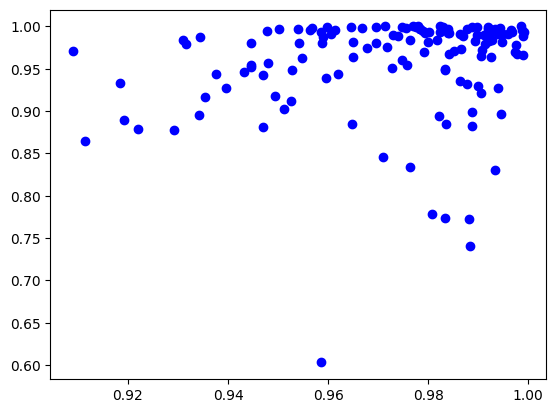

In [75]:
dataset = train_dataset
print(len(list(dataset)))
all_ratios = np.zeros(len(list(dataset)))
all_val = np.zeros(len(list(dataset)))
i = 0
i90 = 0
for example in dataset:
  tinp = example[0]
  ttar = example[1]
  #prediction = generator(tinp, training=True)
  prediction = generator.predict(tinp,verbose=0)
  ttar = tf.squeeze(ttar, axis=0)
  ttar = tf.squeeze(ttar, axis=-1)
  rtimage = ttar

  prediction = tf.squeeze(prediction, axis=0)
  prediction = tf.squeeze(prediction, axis=-1)
  prediction = prediction

  pdos = tinp[0,...,0].numpy()
  cbct = tinp[0,...,1].numpy()
  half = tinp[0,...,2].numpy()


  rtprim = pdos*(1.0*np.exp(0.538066**cbct*cbct-2.970*cbct-0.04349))
  predprim =  pdos*(1.0*np.exp(0.538066**cbct*cbct-2.970*cbct-0.04349))

  rtfull = pdos*(1.0*np.exp(0.538066**cbct*cbct-2.970*cbct-0.04349)) + rtimage
  predfull = pdos*(1.0*np.exp(0.538066**cbct*cbct-2.970*cbct-0.04349)) + prediction

  tmask = rtfull < np.max(rtfull) *0.1


  rtfrac = rtprim/rtfull
  a = np.ma.array(rtprim,mask=tmask)
  b= np.ma.array(rtfull,mask=tmask)

  frac = a.mean()/b.mean()
  if(frac > 1.0):
    frac = 1.0/frac
  print(frac)
  all_val[i] = frac



  rtimage = pdos*(1.0*np.exp(0.538066**cbct*cbct-2.970*cbct-0.04349)) + rtimage
  prediction = pdos*(1.0*np.exp(0.538066**cbct*cbct-2.970*cbct-0.04349)) + prediction


  gamma_test = pymedphys.gamma(coords,rtimage, coords, prediction, **gamma_options,quiet=True)
  valid_gamma = gamma_test[~np.isnan(gamma_test)]
  pass_ratio = np.sum(valid_gamma <= 1) / len(valid_gamma)
  #tf.print(example["fname"])
  print(str(100*pass_ratio) +' ,')
  #print(i)
  all_ratios[i] = pass_ratio


  i = i+1

plt.plot(all_val,all_ratios,'bo')
plt.show()





# print("mean " + str(np.mean(all_ratios)))
# print("STD " + str(np.std(all_ratios)))
# print("max " + str(np.max(all_ratios)))
# print("min " + str(np.min(all_ratios)))
# print("ratio > 90% " + str(float(i90)/float(i)))
# plt.hist(all_ratios)
# #plt.yscale('log')

In [ ]:
example = next(iter(train_dataset))
x = example[0]
y = example[1]
#x, y = next(iterx)
#print(train_len)
#print(valid_len)
#print(test_len)
#plt.imshow(y[0,...,0])
prediction = generator.predict(x)
prediction = tf.squeeze(prediction, axis=0)
prediction = tf.squeeze(prediction, axis=-1)
rt = y[0,...,0].numpy()

pdos = x[0,...,0].numpy()
cbct = x[0,...,1].numpy()

plt.figure(figsize=(10, 10))
plt.subplot(1,3,1)

plt.imshow(rt)
#plt.plot(pdos[128,1:256],'b')
#plt.plot(cbct[128,1:256],'r')

#plt.show()

cbctval = []
ratio = []
pdosval = []
pred = []

rtmax = rt.max(0).max(-1)
#print(rtmax)

for i in range(0,256):
  for j in range(0,256):
    if(rt[i,j] > rtmax*0.5):
      cbctval = np.append(cbctval,cbct[i,j])
      pdosval = np.append(pdosval,pdos[i,j])
      ratio = np.append(ratio,rt[i,j]/pdos[i,j])
      pred = np.append(pred,prediction[i,j]/pdos[i,j])

plt.subplot(1,3,2)
plt.plot(cbctval,ratio,'bo')
plt.plot(cbctval,pred,'ro')
#xp = np.arange(0, 200.0, 0.1)
#yp = np.exp(-4.0/255 * xp) + 0.15/255 * xp - 0.1/65025 * xp * xp
# #yp = pdosval*( np.exp(-4.0/255 *cbctval) + 0.15/255 * cbctval - 0.1/65025 * cbctval * cbctval)
xp = np.arange(0, 1.0, 0.01)
#yp = np.exp(-4.0 * xp) + 0.15 * xp -0.1* xp * xp
yp = np.exp(0.7885*xp*xp-3.523*xp-0.04555)
#yp = np.exp(-4.0 * xp) -0.1* xp * xp

plt.plot(xp, yp,'r')

#plt.subplot(1,3,3)
#plt.plot(rt[128,1:256]/pdos[128,1:256],'b')
#plt.plot(pdos[128,1:256],'r')
#plt.plot(rt[128,1:256],'b')

In [ ]:
generator.summary()